# Analysis of mixed BDF/EX time integration

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets.widgets import interact
from scipy.optimize import minimize
from scipy.optimize import basinhopping

## Introduction

Consider the PDE:
$$ \frac{d \phi}{d t} = L(\phi) $$
where $L$ is a linear operator.
First, we discretize the LHS with a backwards difference formula (BDF):
$$ \sum \beta_i \phi^{n-i} = L(\phi^n) $$
where $\beta$ are the BDF coefficients.
Next, we discretize the RHS with explicit extrapolation (EX), likely motivated by discrete versions of $L$ having a high condition number:
\begin{equation}
\sum_{i=0} \beta_i \phi^{n-i} = \sum_{i=1} \chi_i L \phi^{n-i}
\end{equation}
where $\chi$ are the extrapolation coefficients.

The standard coefficients, those which achieve maximal convergence order, are found below.

In [2]:
bdf1 = np.array([  1., -  1.,   0.,    0.,   0.,   0.,  0.])/ 1.
bdf2 = np.array([  3., -  4.,   1.,    0.,   0.,   0.,  0.])/ 2.
bdf3 = np.array([ 11., - 18.,   9., -  2.,   0.,   0.,  0.])/ 6.
bdf4 = np.array([ 25., - 48.,  36., - 16.,   3.,   0.,  0.])/12.
bdf5 = np.array([137., -200., 300., -200.,  75., -12.,  0.])/60.
bdf6 = np.array([147., -360., 450., -400., 225., -72., 10.])/60.
ex1  = np.array([0., 1.,   0.,  0.,   0., 0.,  0.])
ex2  = np.array([0., 2., - 1.,  0.,   0., 0.,  0.])
ex3  = np.array([0., 3., - 3.,  1.,   0., 0.,  0.])
ex4  = np.array([0., 4., - 6.,  4., - 1., 0.,  0.])
ex5  = np.array([0., 5., -10., 10., - 5., 1.,  0.])
ex6  = np.array([0., 6., -15., 20., -15., 6., -1.])

To evaluate the stability, we consider model solutions with $L \tilde \phi^i = \lambda_x \phi^i$ and $\phi^{i+1} = \lambda_t \phi^i$.
The discrete equation becomes:
\begin{equation}
\sum_{i=0} \beta_i \lambda_t^{-i} = \lambda_x \sum_{i=1} \chi_i \lambda_t^{-i}
\end{equation}
Which can easily be solved for $\lambda_x$:
\begin{equation}
\lambda_x = \frac{\sum_{i=0} \beta_i \lambda_t^{-i}}{\sum_{i=1} \chi_i \lambda_t^{-i}}
\end{equation}
The method is stable iff $\left| \lambda_t \right| \le 1$, so the stability region of $\lambda_x$ is traced by solving the above for $\lambda_t = \left\{e^{i \theta} : \theta \in [0,2\pi)\right\}$.

BDF/EX schemes are frequently used to advance the convection operator, which can be formulated to be skew-symmetric with purely imaginary eigenvalues.  In this context, the stability constraint is given by the first crossing of the imaginary axis.

The code-block below traces the stability region and returns the location of the first crossing of the imaginary axis.

In [3]:
theta = np.linspace(0, 2*np.pi, endpoint=False, num=512)
E = np.zeros((theta.shape[0], 7), dtype=complex)
i = complex(0., 1.)
E[:,0] = 1. 
E[:,1] = np.exp(-i*theta)
E[:,2] = np.exp(-2*i*theta)
E[:,3] = np.exp(-3.*i*theta)
E[:,4] = np.exp(-4.*i*theta)
E[:,5] = np.exp(-5.*i*theta)
E[:,6] = np.exp(-6.*i*theta)

def stab_region(time, space, num=512, plot=True, label=""):    
    sol = np.dot(E, time) / np.dot(E, space)
    if plot:
        plt.plot(np.real(sol), np.imag(sol), label=label)
        plt.grid(True)
        if label is not None:
            plt.legend()
    for i in range(1, len(theta)):
        if np.real(sol[i]) < 0.0:
            return np.imag(sol[i-1])
    return 0.

For example, the stability regions of BDF2/EX2 and BDF3/EX3 are below:

The maximum convection eigenvalue for BDF2/EX2 is 0.0
The maximum convection eigenvalue for BDF3/EX3 is 0.6328726995106767


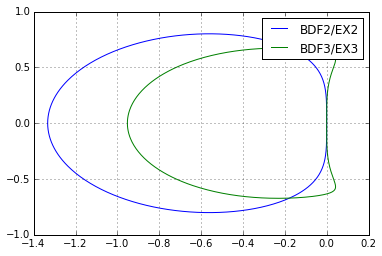

In [4]:
print("The maximum convection eigenvalue for BDF2/EX2 is {}".format(
        stab_region(bdf2, ex2, label="BDF2/EX2")))
print("The maximum convection eigenvalue for BDF3/EX3 is {}".format(
        stab_region(bdf3, ex3, label="BDF3/EX3")))

From this, it is clear to see that BDF2/EX2 is not suitable for the convection operator but BDF3/EX3 is.  
Interestingly, BDF2/EX3 is stable, so this is the 2nd order scheme implemented in codes like Nek5000.

The maximum convection eigenvalue for BDF2/EX2 is 0.6342392815740996


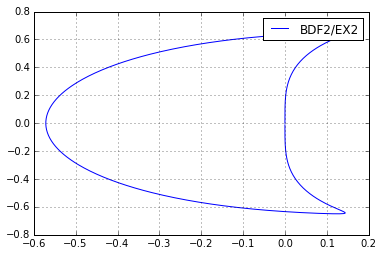

In [5]:
print("The maximum convection eigenvalue for BDF2/EX2 is {}".format(
        stab_region(bdf2, ex3, label="BDF2/EX2")))

## Mixing BDF3/EX3 and BDF2/EX2

Following the method of Vatsa et al. for BDF2OPT, we can mix the coefficients of the second and third order schemes to produce 2nd order schemes with different stability regions and leading order error coefficients.
In this case, we have two sets of coefficients that can be mixed separately, so we need two mixing parameters: let $\alpha$ mix the extrapolation coefficients and $\beta$ mix the BDF coefficients.

In [6]:
def mix_bdfex_23(alpha, beta, plot=False):
    res = stab_region((1.-beta)*bdf2+beta*bdf3,
                      (1.-alpha)*ex2+alpha*ex3,
                     plot=plot);
    if plot:
        print("The eigenvalue for BDF/EX-2,3({},{}) is {}".format(alpha, beta, res))
    return res

The eigenvalue for BDF/EX-2,3(0.5,0.5) is 0.0


/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


array(0.0)

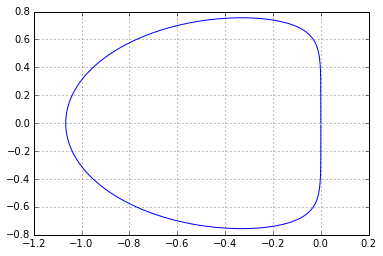

In [7]:
interact(mix_bdfex_23, alpha=.5, beta=.5, plot=True);

We can maximize the stability constraint.  The constraint $\alpha \ge 0$ must be added, because $\alpha < 0$ consistently results in instability (I don't know why). 

The eigenvalue for BDF/EX-2,3(0.008213611827290492,-1.4840621333224489) is 0.9944386237945341


/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


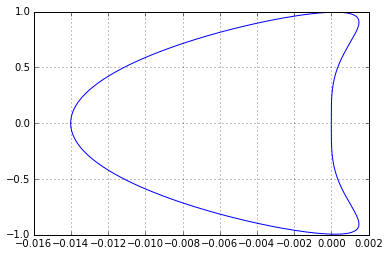

In [8]:
def wrap(x):
    return -mix_bdfex_23(x[0], x[1])
def accept(f_new, x_new, f_old, x_old):
    if x_new[0] < 0:
        return False
    return True
res = basinhopping(wrap, 
                   [1.0, 0.0], 
                   accept_test=accept,
                   minimizer_kwargs={'method': 'SLSQP', 'bounds': [(0, None), (None, None)]}, 
                   niter=1000, 
                   niter_success=500, 
                   T=0.01)
mix_bdfex_23(res.x[0], res.x[1], plot=True);

And plot the stability constraint in the neighborhood of the minimum:

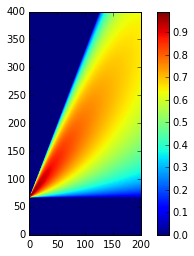

In [9]:
n = 200
alphas = np.linspace(0., 1., num=n)
betas = np.linspace(-2.0, 1.0, num=2*n)
cfls = np.zeros((n,2*n))
for i in range(n):
    for j in range(2*n):
        cfls[i,j] = mix_bdfex_23(alphas[i], betas[j])
plt.imshow(cfls.transpose(), origin='lower')
plt.colorbar()
foo = np.unravel_index(np.argmax(cfls), cfls.shape)

## Mixing BDF/EX-N and BDF/EX-N+1

The same procedure can be used to mix BDF/EX3 and BDF/EX4.

In [10]:
def mix_bdfex_34(alpha, beta, plot=False):
    res = stab_region((1.-beta)*bdf3+beta*bdf4,
                      (1.-alpha)*ex3+alpha*ex4,
                     plot=plot);
    if plot:
        print("The eigenvalue for BDF/EX-3,4({},{}) is {}".format(alpha, beta, res))
    return res

The eigenvalue for BDF/EX-3,4(0.5,0.5) is 0.6461747105022502


/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


array(0.6461747105022502)

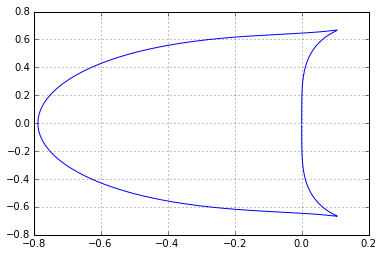

In [11]:
interact(mix_bdfex_34, alpha=.5, beta=.5, plot=True);

We can maximize the stability constraint.  Again, we must impose $\alpha \ge 0$.

The eigenvalue for BDF/EX-3,4(0.0,-1.4626299835761611) is 0.890406165898364


/home/maxhutch/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


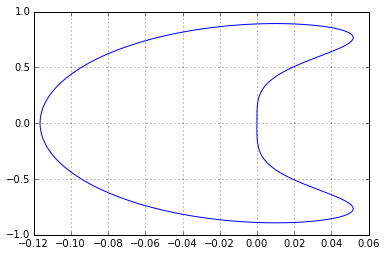

In [12]:
def wrap(x):
    return -mix_bdfex_34(x[0], x[1])
def accept(f_new, x_new, f_old, x_old):
    if x_new[0] < 0:
        return False
    return True
res = basinhopping(wrap, 
                   [0.5, 0.5], 
                   accept_test=accept,
                   minimizer_kwargs={'method': 'SLSQP', 'bounds': [(0., None), (None, None)]}, 
                   niter=1000, 
                   niter_success=500, 
                   T=0.01)
mix_bdfex_34(res.x[0], res.x[1], plot=True);

And plot the stability constraint in the neighborhood of the minimum:

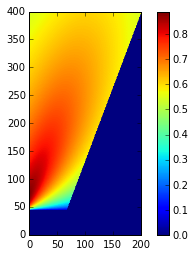

In [13]:
n = 200
alphas = np.linspace(0., 1., num=n)
betas = np.linspace(-2.0, 1.0, num=2*n)
cfls = np.zeros((n,2*n))
for i in range(n):
    for j in range(2*n):
        cfls[i,j] = mix_bdfex_34(alphas[i], betas[j])
plt.imshow(cfls.transpose(), origin='lower')
plt.colorbar()
foo = np.unravel_index(np.argmax(cfls), cfls.shape)